## Iris dataset test

In [2]:
# Handle import
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import TensorBoard

from shapley_analyzer.shapley import calculate_shapely_for_model
from shapley_analyzer.prepare_input_data import convert_map_to_arrays

# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# Load Iris data set

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Scale data to have mean 0 and variance 1
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.5, random_state=2)
n_features = X.shape[1]
n_classes = Y.shape[1]

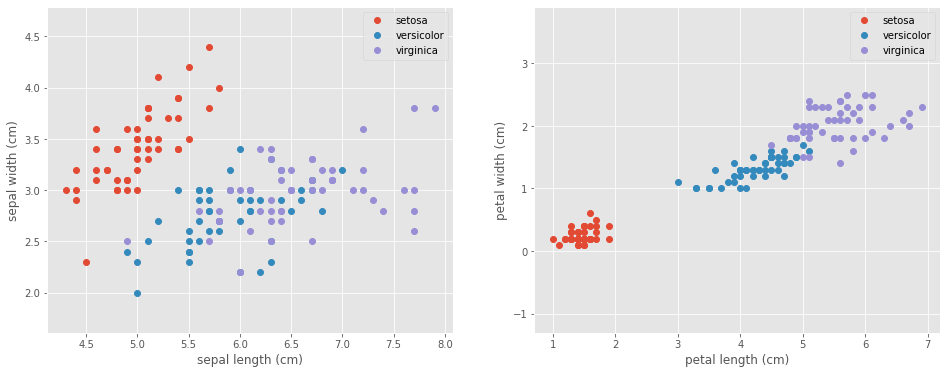

In [4]:
# Visualize the loaded data set

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend()

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend()

In [5]:
# Create three models with different number of layers (2, 4, 8)

def create_custom_model(input_dim, output_dim, nodes, n=1, name='model'):
    def create_iris_model():
        # Create model
        iris_model = Sequential(name=name)
        for i in range(n):
            iris_model.add(Dense(nodes, input_dim=input_dim, activation='relu'))
        iris_model.add(Dense(output_dim, activation='softmax'))

        # Compile model
        iris_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])
        return iris_model
    return create_iris_model

models = [create_custom_model(n_features, n_classes, 8, i, 'model_{}'.format(i))
          for i in range(1, 4)]

for create_model in models:
    create_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 139
Trainable params: 139
Non-tr

In [6]:
# Train models

history_dict = {}

# TensorBoard Callback
cb = TensorBoard()

for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    history_callback = model.fit(X_train, Y_train,
                                 batch_size=5,
                                 epochs=50,
                                 verbose=0,
                                 validation_data=(X_test, Y_test),
                                 callbacks=[cb])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    history_dict[model.name] = [history_callback, model]

Model name: model_1
Test loss: 0.2721746265888214
Test accuracy: 0.9333333373069763
Model name: model_2
Test loss: 0.2363334447145462
Test accuracy: 0.9200000166893005
Model name: model_3
Test loss: 0.15040141344070435
Test accuracy: 0.9466666579246521


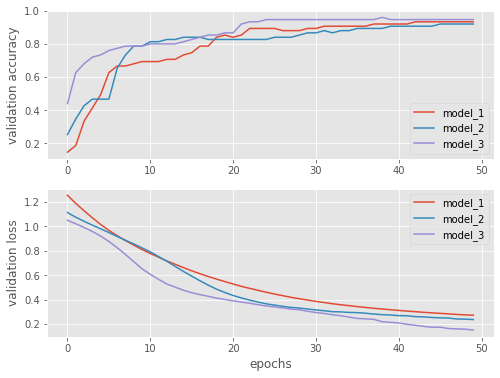

In [7]:
# Plot training results

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

for model_name in history_dict:
    val_accuracy = history_dict[model_name][0].history['val_accuracy']
    val_loss = history_dict[model_name][0].history['val_loss']
    ax1.plot(val_accuracy, label=model_name)
    ax2.plot(val_loss, label=model_name)

ax1.set_ylabel('validation accuracy')
ax2.set_ylabel('validation loss')
ax2.set_xlabel('epochs')
ax1.legend()
ax2.legend();

In [8]:
# Calculate shapely value for different models
shapely, accuracy = {}, {}
for create_model in models:
    model = create_model()
    print('Model name:', model.name)
    model.fit(X_train, Y_train, batch_size=5, epochs=50, verbose=0, validation_data=(X_test, Y_test), callbacks=[cb])
    shapely[model.name], accuracy[model.name]= calculate_shapely_for_model(feature_names, X_test, Y_test, model)
print(shapely)
print(accuracy)

Model name: model_1
8/8 [==============================] - 0s 2ms/step - loss: 0.3196 - accuracy: 0.9067
Model name: model_2
8/8 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9467
Model name: model_3
8/8 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.9200
{'model_1': {'sepal length (cm)': 0.024444450934727985, 'sepal width (cm)': 0.00222223252058029, 'petal length (cm)': 0.10777777681748071, 'petal width (cm)': 0.23222223669290543}, 'model_2': {'sepal length (cm)': 0.08777777850627899, 'sepal width (cm)': 0.0855555459856987, 'petal length (cm)': 0.11666665722926459, 'petal width (cm)': 0.2233333388964335}, 'model_3': {'sepal length (cm)': 0.024444453418254852, 'sepal width (cm)': 0.1133333370089531, 'petal length (cm)': 0.14999999354283014, 'petal width (cm)': 0.1688889016707738}}
{'model_1': {'petal width (cm)': 0.7200000286102295, 'sepal width (cm)': 0.4399999976158142, 'petal length (cm)': 0.5866666436195374, 'sepal length (

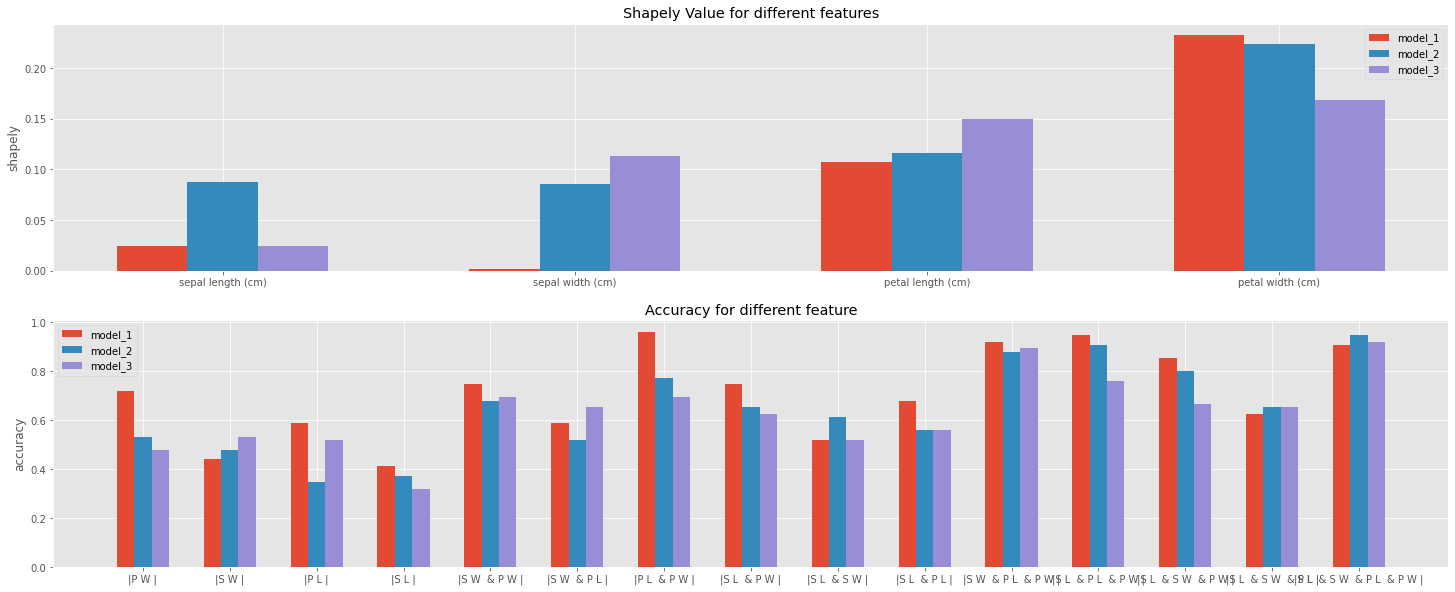

In [9]:
# Plot Shapley Values for Iris data set
model_names = ['model_1', 'model_2', 'model_3']
shapely_arr = convert_map_to_arrays(shapely, feature_names, model_names)
all_features = accuracy['model_1'].keys()
accuracy_arr = convert_map_to_arrays(accuracy, all_features, model_names)

fig, (ax, bx) = plt.subplots(2)
x = np.arange(len(feature_names))

rects1 = ax.bar(x - 0.2, shapely_arr[0], width=0.2, label='model_1')
rects2 = ax.bar(x, shapely_arr[1], width=0.2, label='model_2')
rects3 = ax.bar(x + 0.2, shapely_arr[2], width=0.2, label='model_3')

ax.set_ylabel('shapely')
ax.set_title('Shapely Value for different features')
ax.set_xticks(x)
ax.set_xticklabels(feature_names)
ax.legend()

y = np.arange(len(all_features))

rects4 = bx.bar(y - 0.2, accuracy_arr[0], width=0.2, label='model_1')
rects5 = bx.bar(y, accuracy_arr[1], width=0.2, label='model_2')
rects6 = bx.bar(y + 0.2, accuracy_arr[2], width=0.2, label='model_3')

bx.set_ylabel('accuracy')
bx.set_title('Accuracy for different feature')
bx.set_xticks(y)
labels = []
for label in all_features:
    x = label.replace('(cm)', '')
    x = x.replace('petal', 'P')
    x = x.replace('sepal', 'S')
    x = x.replace('width', 'W')
    x = x.replace('length', 'L')
    labels.append('|' + x  + '|' )

bx.set_xticklabels(labels)
bx.legend()

fig.set_size_inches(25, 10)

plt.show()